In [1]:
import string
import re
from copy import deepcopy
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
np.set_printoptions(precision=2, suppress=True)
import pandas as pd
import sqlparse
from termcolor import colored
import random,math,argparse
from numpy.random.mtrand import sample
import networkx as nx

In [2]:
kw2idx = {
    "START": 0,
    "END": 1,
    "WHERE": 2,
    "GROUPBY": 3,
    "UNION": 4,
    "ORDERBY": 5,
    "JOIN": 6,
    "INTERSECT": 7,
    "EXCEPT": 8,
    "SELECT": 9,
}
idx2kw = {v:k for k,v in kw2idx.items()}
with open("sql_trans_matrix.npy", "rb") as f:
    transition_matrix = np.load(f)
    

In [3]:
## time-space socres
# 可以调
where_op = lambda size_x :  np.random.uniform(0.25, 0.8) * size_x
join_op = lambda size_x, size_y :  np.random.uniform(0.1, 1) * (size_x + size_y)
union_op = lambda size_x, size_y :  np.random.uniform(0.8, 1) * (size_x + size_y)
groupby_op = lambda size_x : np.random.uniform(0.05, 0.2) * size_x
orderby_op = lambda size_x : size_x
intersect_op = lambda size_x, size_y : np.random.uniform(0.4, 1) * min(size_x, size_y)
except_op = lambda size_x, size_y : max(size_x, size_y) - min(size_x, size_y)
select_only_op = lambda size_x : np.random.uniform(0.1, 1.5) * size_x  # TODO : Gamma distribution with 0.1, 1.5

op_size_shift_funcs = {
    "WHERE" : where_op,
    "JOIN" : join_op,
    "GROUPBY": groupby_op,
    "ORDERBY": orderby_op,
    "UNION": union_op,
    "INTERSECT": intersect_op,
    "EXCEPT": except_op,
    "SELECT": select_only_op,
}

In [4]:
MODE = 'default'  # 不用管
N = 10  #number of DAG  nodes
MAX_OUT = 5  #max out_degrees of one node
ALPHA = 1.0   #shape (胖瘦)
BETA = 0.5  #regularity （规则度）

set_dag_size = [20,30,40,50,60,70,80,90]             #random number of DAG  nodes       
set_max_out = [1,2,3,4,5]                              #max out_degrees of one node
set_alpha = [0.5,1.0,1.5]                            #DAG shape
set_beta = [0.0,0.5,1.0,2.0]                         #DAG regularity

<function matplotlib.pyplot.clf()>

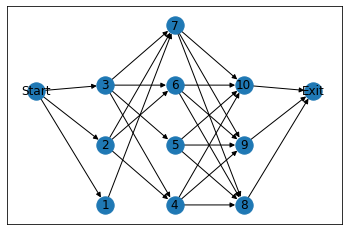

In [5]:
def DAGs_generate(mode = 'default', n = 10, max_out = 2,alpha = 1,beta = 1.0):
    ##############################################initialize############################################
    if mode != 'default':
        N = random.sample(set_dag_size,1)[0]
        MAX_OUT = random.sample(set_max_out,1)[0]
        ALPHA = random.sample(set_alpha,1)[0]
        BETA = random.sample(set_alpha,1)[0]
    else: 
        N = n
        MAX_OUT = max_out
        ALPHA = alpha
        BETA = beta

    length = math.floor(math.sqrt(N)/ALPHA)
    mean_value = N/length
    random_num = np.random.normal(loc = mean_value, scale = BETA,  size = (length,1))    
    ###############################################division#############################################
    position = {'Start':(0,4),'Exit':(10,4)}
    generate_num = 0
    dag_num = 1
    dag_list = [] 
    for i in range(len(random_num)):
        dag_list.append([]) 
        for j in range(math.ceil(random_num[i])):
            dag_list[i].append(j)
        generate_num += len(dag_list[i])

    if generate_num != N:
        if generate_num<N:
            for i in range(N-generate_num):
                index = random.randrange(0,length,1)
                dag_list[index].append(len(dag_list[index]))
        if generate_num>N:
            i = 0
            while i < generate_num-N:
                index = random.randrange(0,length,1)
                if len(dag_list[index])<=1:
                    continue
                else:
                    del dag_list[index][-1]
                    i += 1

    dag_list_update = []
    pos = 1
    max_pos = 0
    for i in range(length):
        dag_list_update.append(list(range(dag_num,dag_num+len(dag_list[i]))))
        dag_num += len(dag_list_update[i])
        pos = 1
        for j in dag_list_update[i]:
            position[j] = (3*(i+1),pos)
            pos += 5
        max_pos = pos if pos > max_pos else max_pos
        position['Start']=(0,max_pos/2)
        position['Exit']=(3*(length+1),max_pos/2)

    ############################################link#####################################################
    in_degrees = [0]*N            
    out_degrees = [0]*N             
    edges = []                          
    pred = 0

    for i in range(length-1):
        sample_list = list(range(len(dag_list_update[i+1])))
        for j in range(len(dag_list_update[i])):
            od = random.randrange(1,MAX_OUT+1,1)
            od = len(dag_list_update[i+1]) if len(dag_list_update[i+1])<od else od
            bridge = random.sample(sample_list,od)
            for k in bridge:
                edges.append((dag_list_update[i][j],dag_list_update[i+1][k]))
                in_degrees[pred+len(dag_list_update[i])+k]+=1
                out_degrees[pred+j]+=1 
        pred += len(dag_list_update[i])


    ######################################create start node and exit node################################
    for node,id in enumerate(in_degrees):#给所有没有入边的节点添加入口节点作父亲
        if id ==0:
            edges.append(('Start',node+1))
            in_degrees[node]+=1

    for node,od in enumerate(out_degrees):#给所有没有出边的节点添加出口节点作儿子
        if od ==0:
            edges.append((node+1,'Exit'))
            out_degrees[node]+=1

    #############################################plot###################################################
    return edges,in_degrees,out_degrees,position

def plot_DAG(edges,postion):
    g1 = nx.DiGraph()
    g1.add_edges_from(edges)
    nx.draw_networkx(g1, arrows=True, pos=postion)
    plt.savefig("DAG.png", format="PNG")
    return plt.clf

edges,in_degrees,out_degrees,position = DAGs_generate(MODE, N, MAX_OUT, ALPHA, BETA)
nodes = np.arange(1, len(in_degrees) + 1)
plot_DAG(edges, position)

In [6]:
def markov_generator(num_to_gen=1):
    outputs = []
    for _ in range(num_to_gen):
        generated_seq = ["START"]
        current_kw = "START"
        while current_kw != "END":
            current_kw_idx = kw2idx[current_kw]
            next_prob = transition_matrix[current_kw_idx]
            current_kw = np.random.choice(list(kw2idx.keys()), p=next_prob)
            generated_seq.append(current_kw)
        outputs.append(generated_seq)
    return outputs

def generate_one_node(in_degree): #rejection sampling
    while True:
        chain = markov_generator(1)[0]
        agg_counts = chain.count("JOIN") + chain.count("UNION") + \
                    chain.count("INTERSECT") + chain.count("EXCEPT") # handles both 1-to-1 and n-to-1
        if agg_counts == in_degree - 1:
            return chain
    
def calc_node_level(edges, nodes):
    # Calculate the layer level for each node
    node2parents = {node:[] for node in nodes}
    node2levels = {node: -1 for node in nodes}
    total_known = 0
    for (start_node, end_node) in edges:
        if end_node == "Exit": continue
        node2parents[end_node].append(start_node)
        if start_node == "Start":
            total_known += 1
            node2levels[end_node] = 0
    
    while total_known < len(nodes):
        for node,level in node2levels.items():
            if level != -1: continue
            parents = node2parents[node]
            parent_levels = [node2levels[p] for p in parents]
            if parent_levels.count(-1) == 0:
                max_parent_level = max(parent_levels)
                node2levels[node] = max_parent_level + 1
                total_known += 1
    levels = list(node2levels.values())
    # minus one to convert node_name to node_idx
    parents = [[p-1 for p in node2parents[node] if p != "Start"] for node in nodes]
    return levels, parents

def create_node_info_dict(edges,in_degrees,out_degrees,position, nodes):
    levels, parents = calc_node_level(edges, nodes)
    sql_chain = [] # sorted by the ordering of nodes
    for node in nodes:
        i = node - 1
        ind = in_degrees[i]
        sql_chain.append(generate_one_node(ind))

    node_info_dict = {
        "in_degrees": in_degrees,
        "out_degrees": out_degrees,
        "sql_chain": sql_chain,
        "levels": levels,
        "parents": parents,
        "size_out": [-1 for i in range(len(nodes))],
    }
    return node_info_dict

In [9]:
# [0,1,2,3]
# in_degrees: [5,2,4,6]
# sql_chain: [[xxx], [yyy], [zzz]]
# parents: [[1's parents], [2's parents]...]
# size_out: [-1 as initialization]

In [10]:
def is_n_to_1_op(kw):
    return kw in ["JOIN", "UNION", "INTERSECT", "EXCEPT"]

def compute_one_op_size_shift(kw, current_size, pending_size=None):
    if is_n_to_1_op(kw): # n-to-1
        assert pending_size is not None, f"Keyword '{kw}' expects more than one table."
        return op_size_shift_funcs[kw](current_size, pending_size)
    else: # 1-to-1
        return op_size_shift_funcs[kw](current_size)
    
def trim_chain(chain):  # drop START & END marks
    c = deepcopy(chain)
    if c[0] == "START": c.pop(0)
    if c[-1] == "END": c.pop(-1)
    return c
    
def compute_chain_op_size_shift(chain, dependent_sizes):
    chain = trim_chain(chain)
    if chain == ["SELECT"]: # SELECT only
        return op_size_shift_funcs["SELECT"](dependent_sizes[0])
    
    elif chain.count("SELECT") < 2:  # （1）单SELECT + 一堆非 UNION, INTERSECT, EXCEPT  (2) 无 SELECT 的 Final chain
        current_size = dependent_sizes[0]
        pending_idx = 1
        for kw in chain[1:]: # omit SELECT
            if is_n_to_1_op(kw):
                current_size = compute_one_op_size_shift(kw, current_size, dependent_sizes[pending_idx])
                pending_idx += 1
            else:
                current_size = compute_one_op_size_shift(kw, current_size)
        return current_size
    
    else: # UNION, INTERSECT, EXCEPT -- multiple SELECTs
        str_chain = " ".join(chain)
        select_idx = [elem.span()[0] for elem in re.finditer(r"SELECT", str_chain)]
        sub_chains, sub_dependenies, connectors = [], [], [] # connectors must \in [UNION, INTERSECT, EXCEPT], according to transition mat
        dependency_idx = 0
        for i in range(len(select_idx)):
            if i != len(select_idx) - 1:
                sub_chain = str_chain[select_idx[i]:select_idx[i+1]].strip().split(" ")
                new_dep_idx = dependency_idx + (sub_chain.count("JOIN") + 1)
                sub_dep = dependent_sizes[dependency_idx:new_dep_idx]
                sub_dependenies.append(sub_dep)
                dependency_idx = new_dep_idx
                connectors.append(sub_chain.pop(-1)) # Ends with a connector
                sub_chains.append(sub_chain)
            else:
                sub_chains.append(str_chain[select_idx[i]:].strip().split(" "))
                sub_dep = dependent_sizes[dependency_idx:]
                sub_dependenies.append(sub_dep)

        sub_chain_out_sizes = [compute_chain_op_size_shift(sub_chain,sub_dep) \
                               for sub_chain,sub_dep in zip(sub_chains, sub_dependenies)]
        return compute_chain_op_size_shift(connectors, sub_chain_out_sizes)    
            
            
    
def initialize_base_table_size(base_table_sizes, level2node, node_info_dict):
    base_nodes = level2node[0]
    for node in base_nodes:
        base_table_size = np.random.choice(base_table_sizes) #####################
        chain = node_info_dict["sql_chain"][node]
        size_out = compute_chain_op_size_shift(chain, [base_table_size]) #compute level 0 nodes' output size
        
        node_info_dict["size_out"][node] = size_out
                
            
    
def dag_execution(node_info_dict, base_table_sizes):
    all_levels = sorted(list(set(node_info_dict["levels"])))
    level2node = {lv:[i for i, l in enumerate(node_info_dict["levels"]) if l == lv] for lv in all_levels}
    initialize_base_table_size(base_table_sizes, level2node, node_info_dict)
    for lv, nodes in level2node.items(): # this is automatically sorted
        if lv == 0: continue
        for node in nodes: # skip level 0
            parents_size_out = [node_info_dict["size_out"][p] for p in node_info_dict["parents"][node]]
            assert np.any(np.array(parents_size_out) != -1) # all parents' output sizes are computed
            size_out = compute_chain_op_size_shift(node_info_dict["sql_chain"][node], parents_size_out)
            node_info_dict["size_out"][node] = size_out        
    print("Execution Done!")
#     print('All size information are stored in node_info_dict["size_out"].')
    

In [13]:
# c = "SELECT WHERE GROUPBY UNION SELECT UNION SELECT WHERE".split(" ")
# c = "START SELECT JOIN WHERE GROUPBY UNION SELECT WHERE UNION SELECT JOIN WHERE".split(" ")
# [[SELECT JOIN WHERE GROUPBY], [SELECT WHERE], [SELECT JOIN WHERE]] ->   ["UNION", "UNION"]
# c = "START SELECT  END".split(" ")
# dep = [2000, 1000]
# compute_chain_op_size_shift(c, dep)

In [14]:
def run_dag_experiments(base_table_sizes, n_experiments):
    execution_results = []
    for i in range(n_experiments):
        # Generate DAG
        N = np.random.randint(30, 100)  #number of DAG  nodes
        MAX_OUT = 4  #max out_degrees of one node
        ALPHA = np.random.uniform(0.2, 1.5)   #shape (胖瘦)
        BETA = np.random.uniform(0.2, 1.5)  #regularity （规则度）
        print(f"{i}: Generating DAG... (size={N})")
        edges,in_degrees,out_degrees,position = DAGs_generate(MODE, N, MAX_OUT, ALPHA, BETA)
        print(f"{i}: DAG Generatoin done!")
        
        # Construct initial node_info_dict
        node_names = np.arange(1, len(in_degrees) + 1)
        node_info_dict = create_node_info_dict(edges,in_degrees,out_degrees,position, node_names)
        
        # Execution
        dag_execution(node_info_dict, base_table_sizes)
        execution_results.append(node_info_dict)
    return execution_results

In [15]:
base_table_sizes = np.arange(1, 10) * 10000
results = run_dag_experiments(base_table_sizes, 100)

0: Generating DAG... (size=66)
0: DAG Generatoin done!
Execution Done!
1: Generating DAG... (size=38)
1: DAG Generatoin done!
Execution Done!
2: Generating DAG... (size=78)
2: DAG Generatoin done!
Execution Done!
3: Generating DAG... (size=63)
3: DAG Generatoin done!
Execution Done!
4: Generating DAG... (size=38)
4: DAG Generatoin done!
Execution Done!
5: Generating DAG... (size=75)
5: DAG Generatoin done!
Execution Done!
6: Generating DAG... (size=37)
6: DAG Generatoin done!
Execution Done!
7: Generating DAG... (size=76)
7: DAG Generatoin done!
Execution Done!
8: Generating DAG... (size=76)
8: DAG Generatoin done!
Execution Done!
9: Generating DAG... (size=65)
9: DAG Generatoin done!
Execution Done!
10: Generating DAG... (size=90)
10: DAG Generatoin done!
Execution Done!
11: Generating DAG... (size=35)
11: DAG Generatoin done!
Execution Done!
12: Generating DAG... (size=66)
12: DAG Generatoin done!
Execution Done!
13: Generating DAG... (size=77)
13: DAG Generatoin done!
Execution Done

In [12]:
[0, 1, 2, 3,]

[0, 1, 2, 3]